In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from db_util import DataBase
from feature_extractor import FeatureExtractor
from analysis_util import StockDirectionAnalyzer

In [3]:
import importlib
import db_util
importlib.reload(db_util)
from db_util import DataBase

In [3]:
db = DataBase(db_path='../data/project1.db')
df = db.get_data(ticker='BTC-USD', period='2y', interval='1d')
print(df.shape)

[*********************100%%**********************]  1 of 1 completed

(730, 8)


In [4]:
df.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='object')

In [5]:
fe = FeatureExtractor(df)
df['adl'] = fe.accumulation_distribution_line()
df['aroon_high'], df['aroon_low'], df['aroon_oscillator'] = fe.aroon()
df['atr'] = fe.average_true_range()
df['atr_p'] = fe.average_true_range_percentage()
df['+di'], df['-di'], df['adx'] = fe.average_directional_index()
df['bop'] = fe.balance_of_power()
df['bb_upper'], df['bb_middle'], df['bb_lower'] = fe.bollinger_band()
df['bb_bandwidth'] = fe.bollinger_bandwidth()
df['bb_p'] = fe.bollinger_percentage()
df['cp_close_1d'] = fe.change_percentage(lookback=1)
df['cp_close_5d'] = fe.change_percentage(lookback=5)
df['cd_close_1d'] = fe.change_direction(lookback=1)
df['cd_close_5d'] = fe.change_direction(lookback=5)
df['cmf'] = fe.chainkin_money_flow()
df['co'] = fe.chainkin_oscillator()
df['fi'] = fe.force_index()
df['macd_line'], df['signal_line'], df['macd_histogram'] = fe.macd()
df['so_k'], df['so_d'] = fe.stochastic_oscillator()

In [6]:
exclude_features = ['ticker', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
features = [c for c in df.columns if c not in exclude_features]
X = df[features]
y = df['close'].shift(-1) > df['close']

In [7]:
EXCLUDE_FOR_TRAINING = 25
RESERVE_FOR_TESTING = 150

sc = StandardScaler()
X_sc = sc.fit_transform(X[EXCLUDE_FOR_TRAINING:])
X_train = X_sc[:-RESERVE_FOR_TESTING, :]
y_train = y.iloc[EXCLUDE_FOR_TRAINING:-RESERVE_FOR_TESTING]
X_test = X_sc[-RESERVE_FOR_TESTING:, :]
y_test = y.iloc[-RESERVE_FOR_TESTING:]
price_train = df['close'].values[EXCLUDE_FOR_TRAINING:-RESERVE_FOR_TESTING]
price_test = df['close'].values[-RESERVE_FOR_TESTING:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(555, 27) (150, 27) (555,) (150,)



        Up correct: 56.00%;
        Down correct: 59.70%;
        Accuracy: 58.20%;
        

        Up correct: 57.89%;
        Down correct: 51.79%;
        Accuracy: 53.33%;
        


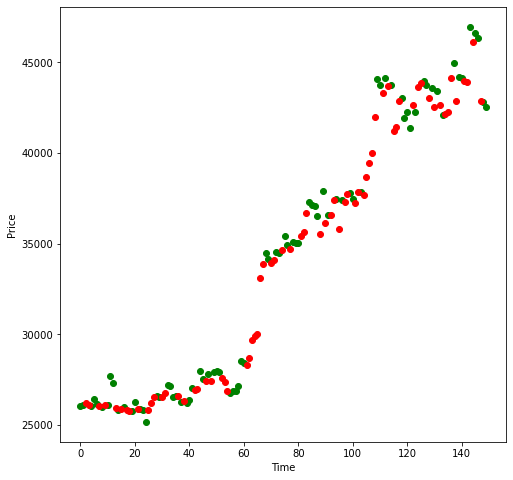

(57.89473684210527, 51.78571428571429, 53.333333333333336)

In [8]:
# Logistic Regression
model = LogisticRegression(verbose=0, n_jobs=-1)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_analyzer = StockDirectionAnalyzer(y_train, y_train_pred, price_train)
train_analyzer.analyze(plot=False)
test_analyzer = StockDirectionAnalyzer(y_test, y_test_pred, price_test)
test_analyzer.analyze()


        Up correct: 78.24%;
        Down correct: 80.89%;
        Accuracy: 79.64%;
        

        Up correct: 57.50%;
        Down correct: 48.57%;
        Accuracy: 53.33%;
        


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


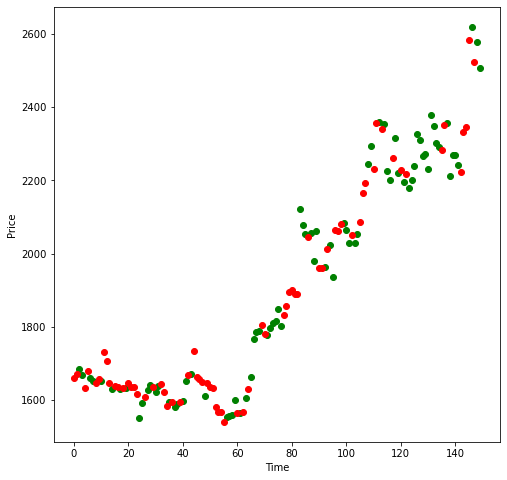

(57.49999999999999, 48.57142857142857, 53.333333333333336)

In [17]:
# Random Forest
model = RandomForestClassifier(
    max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=10,
    verbose=1, n_jobs=-1
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_analyzer = StockDirectionAnalyzer(y_train, y_train_pred, price_train)
train_analyzer.analyze(plot=False)
test_analyzer = StockDirectionAnalyzer(y_test, y_test_pred, price_test)
test_analyzer.analyze()

In [15]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=1, cv=4
)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 10}
Best score:  0.5440777812532582



        Up correct: 63.45%;
        Down correct: 59.27%;
        Accuracy: 60.36%;
        

        Up correct: 55.17%;
        Down correct: 50.41%;
        Accuracy: 51.33%;
        


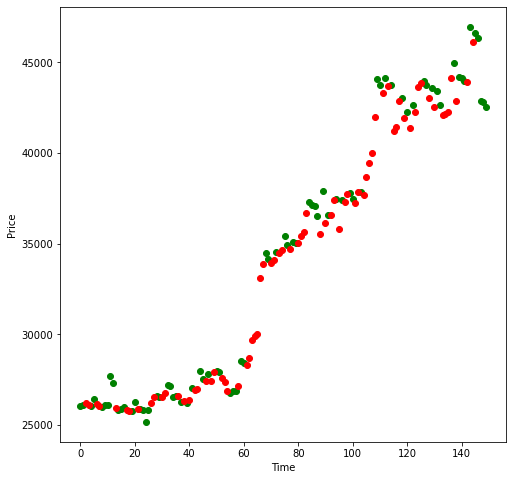

(55.172413793103445, 50.413223140495866, 51.33333333333333)

In [11]:
# XGBoost
model = xgb.XGBClassifier(
    colsample_bytree=0.6, eta=0.1, gamma=10, max_depth=3, min_child_weight=10, subsample=0.5
)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_analyzer = StockDirectionAnalyzer(y_train, y_train_pred, price_train)
train_analyzer.analyze(plot=False)
test_analyzer = StockDirectionAnalyzer(y_test, y_test_pred, price_test)
test_analyzer.analyze()

In [10]:
# Grid CV
param_grid = {
    'colsample_bytree': [0.6, 0.8, 1],
    'subsample': [0.2, 0.3, 0.5],
    'max_depth': [3, 4, 6],
    'gamma': [1, 5, 10],
    'min_child_weight': [1, 5, 10],
    'eta': [0.1, 0.2, 0.3],
}

rf = xgb.XGBClassifier()
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, n_jobs=-1, verbose=1, cv=4
)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 4 folds for each of 729 candidates, totalling 2916 fits
Best parameters:  {'colsample_bytree': 0.6, 'eta': 0.1, 'gamma': 10, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.5}
Best score:  0.5657387133771243
